# DO NOT USE RUN ALL, MUST UPDATE NUMPY. WILL RESTART RUNTIME

In [13]:
%pip install --upgrade scipy
%pip install --upgrade numpy
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# YOU MAY NOW RUN ALL

## Install MMPose

We recommend to use a conda environment to install mmpose and its dependencies. And compilers `nvcc` and `gcc` are required.

In [1]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/usr/local/bin/python


In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
%pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
%pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

# install mmdet for inference demo
%pip install mmdet

%pip install mmpose

# # clone mmpose repo
%rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose

# # install mmpose dependencies
%pip install -r requirements.txt

# # install mmpose in develop mode
%pip install -e .

%pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'mmpose'...
remote: Enumerating objects: 23679, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (254/254), done.
remote: Total 23679 (delta 125), reused 155 (delta 44), pack-reused 23380
Receiving objects: 100% (23679/23679), 26.81 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (16860/16860), done.
/content/mmpose
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-

In [3]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.10.0+cu111 True
torchvision version: 0.11.0+cu111
mmpose version: 0.29.0
cuda version: 11.1
compiler information: GCC 7.3


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
from mmcv.cnn import constant_init, normal_init

# MMPOSE STRUCTURE FILE


In [5]:
import logging
from abc import ABCMeta, abstractmethod

import torch.nn as nn


class BaseBackbone(nn.Module, metaclass=ABCMeta):
    """Base backbone.
    This class defines the basic functions of a backbone. Any backbone that
    inherits this class should at least define its own `forward` function.
    """

    def init_weights(self, pretrained=None, patch_padding='pad'):
        """Init backbone weights.
        Args:
            pretrained (str | None): If pretrained is a string, then it
                initializes backbone weights by loading the pretrained
                checkpoint. If pretrained is None, then it follows default
                initializer or customized initializer in subclasses.
        """
        if isinstance(pretrained, str):
            logger = logging.getLogger()
            load_checkpoint(self, pretrained, strict=False, logger=logger, patch_padding=patch_padding)
        elif pretrained is None:
            # use default initializer or customized initializer in subclasses
            pass
        else:
            raise TypeError('pretrained must be a str or None.'
                            f' But received {type(pretrained)}.')

    @abstractmethod
    def forward(self, x):
        """Forward function.
        Args:
            x (Tensor | tuple[Tensor]): x could be a torch.Tensor or a tuple of
                torch.Tensor, containing input data for forward computation.
        """

# BACKBONE COMPLETE CLASS

In [6]:
class convolutionalBlock(nn.Module):
  def __init__(self,in_channels,channel_size=128,num_channels=3, kernel_size=11):
    super().__init__()
    layers = []
    for i in range(num_channels):
      if i == 0:
        input_channel = in_channels
      else:
        input_channel = channel_size
      layers.append(
          nn.Sequential(
          nn.Conv2d(input_channel, channel_size, kernel_size, padding=(kernel_size - 1) // 2 , bias=False),
          nn.BatchNorm2d(channel_size),
          nn.ReLU(inplace=True)
          )
      )

    self.convolutionModule = nn.Sequential(*layers)

  def forward(self, input):
    output = self.convolutionModule(input)
    return output

In [7]:
from mmpose.models.builder import BACKBONES
@BACKBONES.register_module()
class convolutionPoseMachine(BaseBackbone):
  def __init__(self, in_channels=3, out_channels=17, feature_channels=128, middle_channels=32, num_stages=6, pretrained=None):
    super().__init__()
    self.num_stages = num_stages
    self.stem = nn.Sequential(
        nn.Conv2d(in_channels, 128, 9, padding=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(128, 128, 9, padding=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(128, 128, 9, padding=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(128, 32, 5, padding=2, bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 512, 9, padding=4, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, 1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, out_channels, 1, padding=0, bias=True)
    )
    self.middle = nn.Sequential(
        nn.Conv2d(in_channels, 128, 9, padding=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(128, 128, 9, padding=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(128, 128, 9, padding=4, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    )
    self.convStage = nn.ModuleList([
        convolutionalBlock(middle_channels+out_channels,channel_size=128,kernel_size=11) for i in range(num_stages-1)
    ])
    self.middleConv = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(128, middle_channels, 5, padding=2, bias=False),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True)
        ) for i in range(num_stages-1)
    ])
    self.outConv = nn.ModuleList([
        nn.Sequential(
            nn.Conv2d(feature_channels, feature_channels, 1, padding=0, bias=False),
            nn.BatchNorm2d(feature_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_channels, out_channels, 1, bias=True)
        ) for i in range(num_stages-1)
    ])

  def forward(self, input):
    stageOne = self.stem(input)
    stageMiddle = self.middle(input)
    output = []
    output.append(stageOne)
    for i in range(self.num_stages - 1):
      stageSingle = self.convStage[i]
      outputSingle = self.outConv[i]
      inputFeatures = torch.cat([output[-1], self.middleConv[i](stageMiddle)],1)
      convolutionFeatures = stageSingle(inputFeatures)
      outputFeatures = outputSingle(convolutionFeatures)
      output.append(outputFeatures)
    return output

  def init_weights(self, pretrained=None):
        """Initialize the weights in backbone.
        Args:
            pretrained (str, optional): Path to pre-trained weights.
                Defaults to None.
        """

        if pretrained is None:
          for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    normal_init(m, std=0.001)
                elif isinstance(m, nn.BatchNorm2d):
                    constant_init(m, 1)


# Data Loading

In [8]:
!rm test_image.jpg
!gdown "1d3gK1GuPz4BHq24qtKzn2HOAvgy6k4Hr&confirm=t" 
# https://drive.google.com/file/d/19EFzUXqOgvdHwZvtl4MsubwUjB0JEYFx/view?usp=sharing
# test_image.jpg  https://drive.google.com/file/d/180SKuXNhkfNh_Y91i_HGjp1CgmwoCjpO/view?usp=share_link
# https://drive.google.com/file/d/1wqkqIvSy2_qpd3TZ8RuTWW-agYCcMseE/view?usp=share_link
#https://drive.google.com/file/d/19EFzUXqOgvdHwZvtl4MsubwUjB0JEYFx/view?usp=sharing
#https://drive.google.com/file/d/1NtjcTZI0OCplwwGzJJXL9e185NnZLM9B/view?usp=sharing
#https://drive.google.com/file/d/13Hl-hM4Y5LDvqvp5mOQNRAr9vHwEzbL8/view?usp=sharing
# https://drive.google.com/file/d/1NtjcTZI0OCplwwGzJJXL9e185NnZLM9B/view?usp=share_link
# https://drive.google.com/file/d/1d3gK1GuPz4BHq24qtKzn2HOAvgy6k4Hr/view?usp=share_link

rm: cannot remove 'test_image.jpg': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1d3gK1GuPz4BHq24qtKzn2HOAvgy6k4Hr&confirm=t
To: /content/mmpose/Javier.jpg
100% 166k/166k [00:00<00:00, 106MB/s]


In [9]:
!rm cpm_our_model.pth
!gdown "1NR2udA4L08cN8bGRFJzFt4-tjb7T5uCW&confirm=t" # https://drive.google.com/file/d/1NR2udA4L08cN8bGRFJzFt4-tjb7T5uCW/view?usp=share_link

rm: cannot remove 'cpm_our_model.pth': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1NR2udA4L08cN8bGRFJzFt4-tjb7T5uCW&confirm=t
To: /content/mmpose/cpm_our_model.pth
100% 376M/376M [00:01<00:00, 256MB/s]


In [10]:
!rm cpm_our_config.py
!gdown "1n7likjt08Ce_X-G-gjcptOywCt3EyJKd&confirm=t" # https://drive.google.com/file/d/1n7likjt08Ce_X-G-gjcptOywCt3EyJKd/view?usp=share_link

rm: cannot remove 'cpm_our_config.py': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1n7likjt08Ce_X-G-gjcptOywCt3EyJKd&confirm=t
To: /content/mmpose/cpm_our_config.py
100% 4.36k/4.36k [00:00<00:00, 7.73MB/s]


# Inference with an MMPose model

MMPose provides high level APIs for model inference and training.

load checkpoint from local path: cpm_our_model.pth
load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_mstrain-608_273e_coco/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth


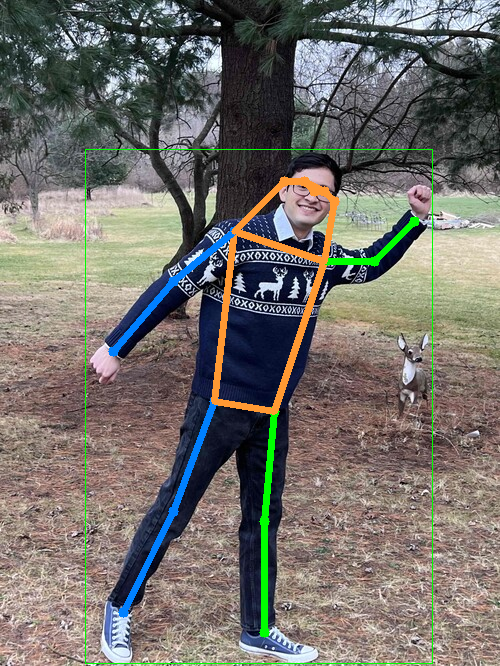

In [13]:
import cv2
from mmpose.apis import inference_top_down_pose_model, init_pose_model, vis_pose_result, process_mmdet_results
from mmdet.apis import inference_detector, init_detector

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

#--------------TODO ------------------------------------------------------

# CHANGE THIS TO OUR STUFF pose_config.py and the latest.pth file
# HOPEFULLY THE AUTHORS WEIGHTS CAN BE SUBSTITUTED WITHOUT ISSUE BUT INVESTIGATE THIS
pose_config = 'cpm_our_config.py'
pose_checkpoint = 'cpm_our_model.pth'

#---------------TODO--------------------------------------------------------------

# THIS IS FOR BOUNDING BOX DETECTOR, THINK WE SHOULD LEAVE IT ALONE
det_config = 'demo/mmdetection_cfg/yolov3_d53_320_273e_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/yolo/yolov3_d53_mstrain-608_273e_coco/yolov3_d53_mstrain-608_273e_coco_20210518_115020-a2c3acb8.pth'

# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

#------------TODO---------------------------------------------------------------
#print("hi")
# TAKE A FEW PICTURES OF YOU WITH INTERESTING POSE
img = 'Javier.jpg'

#-----------TODO----------------------------------------------------------------

# inference detection
mmdet_results = inference_detector(det_model, img)

# extract person (COCO_ID=1) bounding boxes from the detection results
person_results = process_mmdet_results(mmdet_results, cat_id=1)

# inference pose
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    img,
    person_results,
    bbox_thr=0.3,
    format='xyxy',
    dataset=pose_model.cfg.data.test.type)

# show pose estimation results
vis_result = vis_pose_result(
    pose_model,
    img,
    pose_results,
    dataset=pose_model.cfg.data.test.type,
    thickness=5,
    radius=5,
    show=False)
#print(vis_result)
# reduce image size
#vis_result = cv2.resize(vis_result, dsize=None, fx=0.25, fy=0.25)

if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join('pose_results.png')
        cv2.imwrite(file_name, vis_result)
        display(Image(file_name))
else:
    cv2_imshow(vis_result)
    cv2.imwrite('pose_results.png', vis_result)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "pose_results.png" "/content/drive/MyDrive/EECS504_Project/inference"